In [ ]:
pip install SimpleITK

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')
from zipfile import ZipFile
file_name = '/content/drive/My Drive/archive_brain_mri_100.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Mounted at /content/drive
Done


In [ ]:
import os
import SimpleITK as sitk
from tqdm import tqdm
import matplotlib.pyplot as plt

def preprocess_images(input_dir, output_dir):
    """
    Preprocess images by normalizing the FLAIR images and remapping segmentation labels
    without applying registration.
    """
    os.makedirs(output_dir, exist_ok=True)
    subdirs = [subdir for subdir in os.listdir(input_dir) if os.path.isdir(os.path.join(input_dir, subdir))]

    for subdir in tqdm(subdirs, desc="Processing Subdirectories"):
        subfolder_path = os.path.join(input_dir, subdir)
        output_subdir = os.path.join(output_dir, subdir)
        os.makedirs(output_subdir, exist_ok=True)

        flair_file, seg_file = None, None
        for file in os.listdir(subfolder_path):
            if "_flair.nii" in file:
                flair_file = os.path.join(subfolder_path, file)
            elif "_seg.nii" in file:
                seg_file = os.path.join(subfolder_path, file)

        if flair_file and seg_file:
            flair_image = sitk.ReadImage(flair_file)
            seg_image = sitk.ReadImage(seg_file)

            # Normalize FLAIR image
            normalized_flair = sitk.Normalize(flair_image)
            normalized_flair = sitk.Cast(normalized_flair, sitk.sitkFloat32)

            # Remap segmentation labels
            seg_array = sitk.GetArrayFromImage(seg_image)
            seg_array[seg_array == 4] = 3  # Remap label 4 to 3
            remapped_seg = sitk.GetImageFromArray(seg_array)
            remapped_seg.CopyInformation(seg_image)

            # Save preprocessed images
            sitk.WriteImage(normalized_flair, os.path.join(output_subdir, "flair_preprocessed.nii"))
            sitk.WriteImage(remapped_seg, os.path.join(output_subdir, "seg_preprocessed.nii"))

    print(f"Preprocessing complete! Preprocessed data saved to: {output_dir}")


def visualize_alignment(flair_path, seg_path):
    """
    Visualizes the alignment of a FLAIR image and its corresponding segmentation.

    Args:
        flair_path (str): Path to the FLAIR image.
        seg_path (str): Path to the segmentation image.
    """
    flair = sitk.ReadImage(flair_path)
    seg = sitk.ReadImage(seg_path)

    flair_array = sitk.GetArrayFromImage(flair)
    seg_array = sitk.GetArrayFromImage(seg)

    mid_slice = flair_array.shape[0] // 2
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(flair_array[mid_slice], cmap='gray')
    plt.title("FLAIR")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(flair_array[mid_slice], cmap='gray')
    plt.imshow(seg_array[mid_slice], cmap='tab10', alpha=0.5)
    plt.title("FLAIR with Segmentation")
    plt.axis("off")
    plt.show()


# Main Script
if __name__ == "__main__":
    # Paths
    input_dir = "/content/archive_brain_mri_100"
    output_dir = "/content/drive/My Drive/Preprocessed_BraTS20_3"

    # Preprocess Images
    preprocess_images(input_dir, output_dir)



Processing Subdirectories: 100%|██████████| 100/100 [00:33<00:00,  3.00it/s]


Preprocessing complete! Preprocessed data saved to: /content/drive/My Drive/Preprocessed_BraTS20_3


RuntimeError: Exception thrown in SimpleITK ImageFileReader_Execute: /tmp/SimpleITK/Code/IO/src/sitkImageReaderBase.cxx:91:
sitk::ERROR: The file "/content/drive/My Drive/Preprocessed_BraTS20_3/sample/flair_preprocessed.nii" does not exist.

Analyzing Class Distribution: 100%|██████████| 100/100 [00:12<00:00,  8.18it/s]



Class Distribution:
Class 0: 885035293 pixels (99.13%)
Class 1: 1140885 pixels (0.13%)
Class 2: 5163680 pixels (0.58%)
Class 3: 1460142 pixels (0.16%)


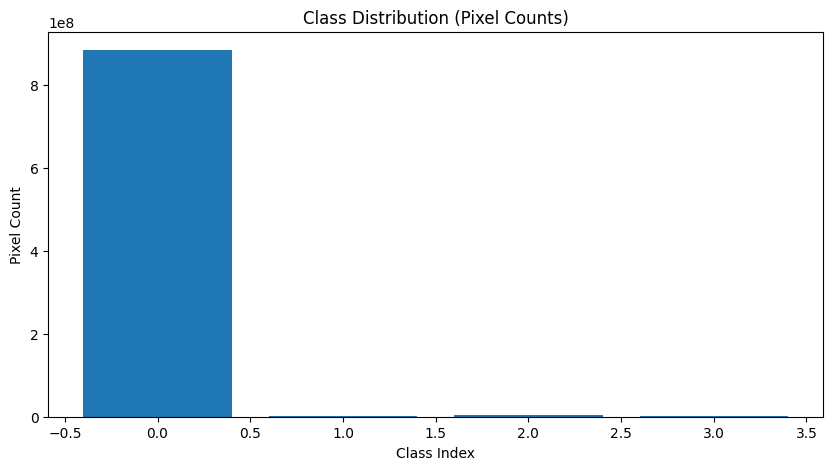

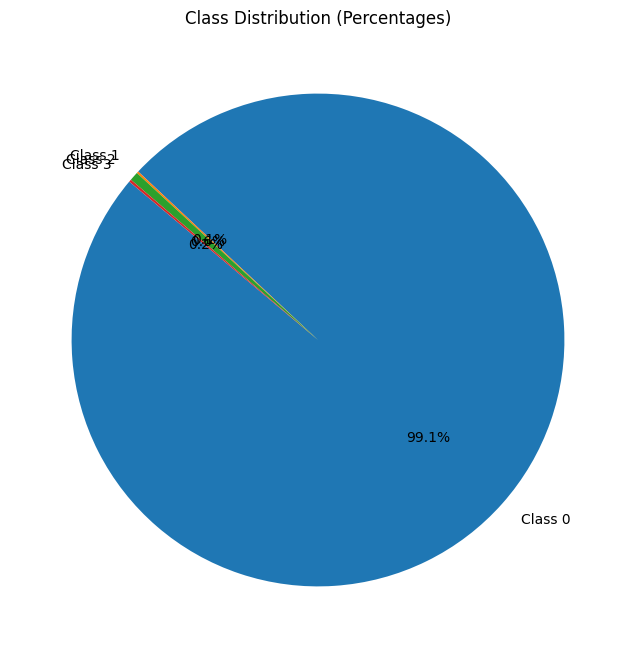

In [ ]:
import os
import numpy as np
import SimpleITK as sitk
from tqdm import tqdm
import matplotlib.pyplot as plt

def analyze_class_distribution(output_dir, num_classes=4):
    """
    Analyze the class distribution in the preprocessed dataset.

    Args:
        output_dir (str): Directory containing the preprocessed segmentation masks.
        num_classes (int): Number of classes in the dataset.

    Returns:
        dict: A dictionary with class indices and their pixel counts and percentages.
    """
    # Initialize a counter for each class
    class_counts = np.zeros(num_classes, dtype=np.int64)

    # Iterate through all subdirectories
    subdirs = [subdir for subdir in os.listdir(output_dir) if os.path.isdir(os.path.join(output_dir, subdir))]
    for subdir in tqdm(subdirs, desc="Analyzing Class Distribution"):
        seg_path = os.path.join(output_dir, subdir, "seg_preprocessed.nii")
        if os.path.exists(seg_path):
            # Read the segmentation mask
            seg_image = sitk.ReadImage(seg_path)
            seg_array = sitk.GetArrayFromImage(seg_image)

            # Count pixels for each class
            for cls in range(num_classes):
                class_counts[cls] += np.sum(seg_array == cls)

    # Total pixel count
    total_pixels = class_counts.sum()

    # Calculate percentages
    class_percentages = (class_counts / total_pixels) * 100

    # Print the results
    print("\nClass Distribution:")
    for cls in range(num_classes):
        print(f"Class {cls}: {class_counts[cls]} pixels ({class_percentages[cls]:.2f}%)")

    # Return the distribution as a dictionary
    return {"counts": class_counts, "percentages": class_percentages}


def plot_class_distribution(class_distribution, num_classes=4):
    """
    Plot the class distribution as a bar chart and a pie chart.

    Args:
        class_distribution (dict): Class distribution with counts and percentages.
        num_classes (int): Number of classes in the dataset.
    """
    counts = class_distribution["counts"]
    percentages = class_distribution["percentages"]

    # Bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(range(num_classes), counts)
    plt.xlabel("Class Index")
    plt.ylabel("Pixel Count")
    plt.title("Class Distribution (Pixel Counts)")
    plt.show()

    # Pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(
        percentages,
        labels=[f"Class {i}" for i in range(num_classes)],
        autopct="%1.1f%%",
        startangle=140
    )
    plt.title("Class Distribution (Percentages)")
    plt.show()


# Main Script
if __name__ == "__main__":
    output_dir = "/content/drive/My Drive/Preprocessed_BraTS20_3"  # Path to your preprocessed masks
    num_classes = 4  # Number of classes in the dataset

    # Analyze class distribution
    class_distribution = analyze_class_distribution(output_dir, num_classes)

    # Plot the class distribution
    plot_class_distribution(class_distribution, num_classes)


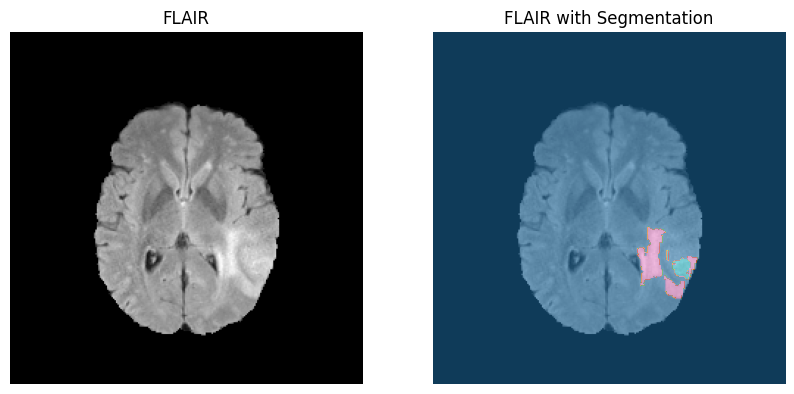

In [ ]:
   # Visualize Alignment for a Sample
sample_flair = os.path.join(output_dir, "BraTS20_Training_003", "flair_preprocessed.nii")
sample_seg = os.path.join(output_dir, "BraTS20_Training_003", "seg_preprocessed.nii")
visualize_alignment(sample_flair, sample_seg)
